In [9]:
from Data import ParticleDataGenerator, ParticleDataset
from Model import ParticleClassifier
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

### General Test

params: 
n data:  1000
n scalar input:  8
n energy matrix:  7
n high resolution energy matrix:  1000
category_mean_diff:  0.5
std_dev_ratio:  1.5
category_ratio:  0.5

number of data:
category 1:  500
category 2:  500

std:
category 1:  [1, 1]
category 2:  [1.5, 1.5]

scalar input shape:
category 1:  (500, 8)
category 2:  (500, 8)
category 1 & 2:  (1000, 8)

covariance of x, y: 
category 1:  [[1, 0.5], [0.5, 1]]
category 2:  [[1.5, 0.75], [0.75, 1.5]]

mean of x, y: 
category 1:  [-0.25, -0.25]
category 2:  [0.25, 0.25]

mean of x, y: 
category 1:  [-0.25, -0.25]
category 2:  [0.25, 0.25]



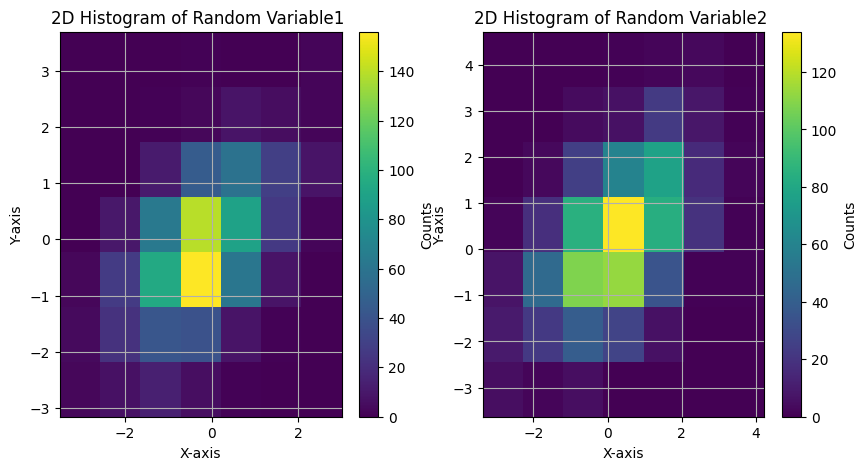

energy distribution shape:  (1000, 7, 7)


In [10]:
### prepare data
n = 1000
n_scalar = 8
energy_matrix_size = 7
high_res_size = 1000 # energy high resolution size
generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)

# Generate the data
category_mean_diff = 0.5
std_dev_ratio = 1.5
category_ratio = 0.5
scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio, debug=True)

# Create the dataset
dataset = ParticleDataset(scalar_inputs, energy_distributions, labels)
train_size = int(0.8 * len(dataset))  # 假設使用80%的數據作為訓練集
test_size = len(dataset) - train_size

# 隨機分割數據集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create a DataLoader instance
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# hyperparameter
learning_rate = 0.001
num_epochs = 10

model = ParticleClassifier(n_scalar, energy_matrix_size)
criterion = nn.BCELoss()  # Binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, train_loader, num_epochs, verbose=True):
    for epoch in range(num_epochs):
        total = 0
        correct = 0
        if verbose:
            for i, (scalars, images, labels) in enumerate(tqdm(train_loader)):
            # for scalars, images, labels in train_loader:
                # forward 
                # in pytorch conv2D is CHW (channel, height, width)
                # print('img size: ', images.unsqueeze(1).shape)
                outputs = model(scalars, images.unsqueeze(1))  # 添加額外的維度作為通道數(channel)
                # print('outputs: ', outputs)
                loss = criterion(outputs[:, 1].unsqueeze(1), labels)

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # predict, compute accuracy
                pred = torch.argmax(outputs, axis=1)
                # print('pred: ', pred)
                # print('pred shape: ', pred.unsqueeze(0).shape)
                # print('labels: ', labels)
                total += labels.size(0)
                correct += torch.sum(torch.eq(pred, labels.squeeze()))
            accuracy = correct / total * 100
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')
        else:
            for scalars, images, labels in train_loader:
                # forward 
                # in pytorch conv2D is CHW (channel, height, width)
                outputs = model(scalars, images.unsqueeze(1))  # 添加額外的維度作為通道數(channel)
                loss = criterion(outputs[:, 1].unsqueeze(1), labels)

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # predict, compute accuracy
                pred = torch.argmax(outputs, axis=1)
                total += labels.size(0)
                correct += torch.sum(torch.eq(pred, labels.squeeze()))
            accuracy = correct / total * 100
            

def test(model, test_loader, verbose=True):
    model.eval() 
    total = 0
    correct = 0
    with torch.no_grad():
        for scalars, images, labels in test_loader:
            # print(images.unsqueeze(1).shape)
            outputs = model(scalars, images.unsqueeze(1))
            pred = torch.argmax(outputs, axis=1)
            total += labels.size(0)
            correct += torch.sum(torch.eq(pred, labels.squeeze()))

    accuracy = 100 * correct / total
    if verbose:
        print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy / 100

train(model, train_loader, num_epochs,verbose=True)
test_acc = test(model, test_loader,verbose=True)
print('test_acc: {:.4f}'.format(test_acc.item()))

100%|██████████| 13/13 [00:00<00:00, 179.98it/s]


Epoch [1/10], Loss: 4.0858, Accuracy: 48.88%


100%|██████████| 13/13 [00:00<00:00, 245.34it/s]


Epoch [2/10], Loss: 3.1757, Accuracy: 48.88%


100%|██████████| 13/13 [00:00<00:00, 297.24it/s]


Epoch [3/10], Loss: 2.1424, Accuracy: 48.88%


100%|██████████| 13/13 [00:00<00:00, 250.13it/s]


Epoch [4/10], Loss: 1.5097, Accuracy: 49.00%


100%|██████████| 13/13 [00:00<00:00, 294.12it/s]


Epoch [5/10], Loss: 0.6699, Accuracy: 50.75%


100%|██████████| 13/13 [00:00<00:00, 270.70it/s]


Epoch [6/10], Loss: 0.6644, Accuracy: 61.62%


100%|██████████| 13/13 [00:00<00:00, 285.19it/s]


Epoch [7/10], Loss: 0.5472, Accuracy: 72.00%


100%|██████████| 13/13 [00:00<00:00, 256.00it/s]


Epoch [8/10], Loss: 0.4935, Accuracy: 72.75%


100%|██████████| 13/13 [00:00<00:00, 246.42it/s]


Epoch [9/10], Loss: 0.4826, Accuracy: 74.12%


100%|██████████| 13/13 [00:00<00:00, 232.68it/s]

Epoch [10/10], Loss: 0.4189, Accuracy: 75.62%
Test Accuracy: 66.00%
test_acc: 0.6600


### mean_diff & std ratio

In [14]:
# generate accuracy table
acc_table = []

n = 1000
n_scalar = 8
energy_matrix_size = 7
high_res_size = 500 # energy high resolution size
# generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)

# Generate the data
category_mean_diff = 0
std_dev_ratio = 1
category_ratio = 0.5
# scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

# hyperparameter
learning_rate = 0.001
num_epochs = 30

model = ParticleClassifier(n_scalar, energy_matrix_size)
criterion = nn.BCELoss()  # Binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in np.arange(0, 2.2, 0.2): # mean diff
    acc_table.append([])
    for j in np.arange(1, 3.2, 0.2): # std ratio
        category_mean_diff = i
        std_dev_ratio = j
        generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)
        scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

        # Create the dataset
        dataset = ParticleDataset(scalar_inputs, energy_distributions, labels)
        train_size = int(0.8 * len(dataset))  # 假設使用80%的數據作為訓練集
        test_size = len(dataset) - train_size

        # 隨機分割數據集
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create a DataLoader instance
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model = ParticleClassifier(n_scalar, img_size=energy_matrix_size)
        criterion = nn.BCELoss()  # Binary classification loss
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train(model=model, train_loader=train_loader, num_epochs=num_epochs, verbose=False)
        test_acc = test(model=model, test_loader=test_loader, verbose=False)
        print('mean_diff: {:.1f} | std ratio: {:.1f} | acc: {:.4f}'.format(category_mean_diff,std_dev_ratio,test_acc.item()))

        acc_table[-1].append(test_acc.item())

mean_diff: 0.0 | std ratio: 1.0 | acc: 0.4600
mean_diff: 0.0 | std ratio: 1.2 | acc: 0.6400
mean_diff: 0.0 | std ratio: 1.4 | acc: 0.7500
mean_diff: 0.0 | std ratio: 1.6 | acc: 0.8100
mean_diff: 0.0 | std ratio: 1.8 | acc: 0.8500
mean_diff: 0.0 | std ratio: 2.0 | acc: 0.8850
mean_diff: 0.0 | std ratio: 2.2 | acc: 0.9200
mean_diff: 0.0 | std ratio: 2.4 | acc: 0.9300
mean_diff: 0.0 | std ratio: 2.6 | acc: 0.9500
mean_diff: 0.0 | std ratio: 2.8 | acc: 0.9650
mean_diff: 0.0 | std ratio: 3.0 | acc: 0.9650
mean_diff: 0.2 | std ratio: 1.0 | acc: 0.5800
mean_diff: 0.2 | std ratio: 1.2 | acc: 0.5900
mean_diff: 0.2 | std ratio: 1.4 | acc: 0.7000
mean_diff: 0.2 | std ratio: 1.6 | acc: 0.7700
mean_diff: 0.2 | std ratio: 1.8 | acc: 0.8250
mean_diff: 0.2 | std ratio: 2.0 | acc: 0.8800
mean_diff: 0.2 | std ratio: 2.2 | acc: 0.8950
mean_diff: 0.2 | std ratio: 2.4 | acc: 0.9250
mean_diff: 0.2 | std ratio: 2.6 | acc: 0.9500
mean_diff: 0.2 | std ratio: 2.8 | acc: 0.9550
mean_diff: 0.2 | std ratio: 3.0 | 

In [15]:
import pandas as pd

mean_diffs = np.arange(0, 2.2, 0.2)  # 不同的mean_diff
std_ratios = np.arange(1, 3.2, 0.2)  # 不同的std_ratio

# 創建DataFrame
df = pd.DataFrame(acc_table, columns=std_ratios, index=mean_diffs)

# 設置列和行的名稱
df.columns.name = 'std_ratio' 
df.index.name = 'mean_diff'

# 顯示表格
df

std_ratio,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0
mean_diff,,,,,,,,,,,
0.0,0.460,0.640,0.750,0.810,0.850,0.885,0.920,0.930,0.950,0.965,0.965
0.2,0.580,0.590,0.700,0.770,0.825,0.880,0.895,0.925,0.950,0.955,0.965
0.4,0.675,0.690,0.725,0.740,0.795,0.870,0.905,0.930,0.935,0.955,0.955
0.6,0.755,0.750,0.765,0.755,0.780,0.825,0.865,0.905,0.930,0.935,0.960
0.8,0.840,0.815,0.805,0.810,0.815,0.840,0.865,0.890,0.915,0.935,0.940
1.0,0.920,0.890,0.850,0.855,0.855,0.875,0.880,0.895,0.900,0.930,0.940
1.2,0.940,0.915,0.915,0.890,0.890,0.895,0.900,0.910,0.915,0.930,0.940
1.4,0.960,0.950,0.930,0.930,0.925,0.910,0.910,0.920,0.925,0.930,0.935
1.6,0.985,0.970,0.960,0.945,0.935,0.930,0.925,0.925,0.940,0.935,0.935


### n_scalar & energy_matrix_size

In [32]:
import pandas as pd
def to_accuracy_df(acc_array):
    n_scalar_list = np.arange(3, 8, 1)  # 不同的mean_diff
    energy_matrix_size_list = [7, 11, 15, 19]  # 不同的std_ratio

    # 創建DataFrame
    df = pd.DataFrame(acc_array, columns=energy_matrix_size_list, index=n_scalar_list)

    # 設置列和行的名稱
    df.columns.name = 'energy_matrix_size' 
    df.index.name = 'n_scalar'

    return df

#### `std_dev_ratio = 1.0`

In [38]:
# generate accuracy table
acc_array = []

n = 1000
n_scalar = 3
energy_matrix_size = 7
high_res_size = 1000 # energy high resolution size
# generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)

# Generate the data
category_mean_diff = 0
std_dev_ratio = 1
category_ratio = 0.5
# scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

# hyperparameter
learning_rate = 0.001
num_epochs = 20

model = ParticleClassifier(n_scalar, energy_matrix_size)
criterion = nn.BCELoss()  # Binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(3, 8): # n scalar
    acc_array.append([])
    for j in [7, 11, 15, 19]: # energy matrix size
        n_scalar = i
        energy_matrix_size = j
        generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)
        scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

        # Create the dataset
        dataset = ParticleDataset(scalar_inputs, energy_distributions, labels)
        train_size = int(0.8 * len(dataset))  # 假設使用80%的數據作為訓練集
        test_size = len(dataset) - train_size

        # 隨機分割數據集
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create a DataLoader instance
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        model = ParticleClassifier(n_scalar, energy_matrix_size)
        criterion = nn.BCELoss()  # Binary classification loss
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train(model=model, train_loader=train_loader, num_epochs=num_epochs, verbose=False)
        test_acc = test(model=model, test_loader=test_loader, verbose=False)
        print('n scalar: {} | energy matrix size: {} | acc: {:.4f}'.format(n_scalar, energy_matrix_size, test_acc.item()))

        acc_array[-1].append(test_acc.item())

n scalar: 3 | energy matrix size: 7 | acc: 0.5850
n scalar: 3 | energy matrix size: 11 | acc: 0.4850
n scalar: 3 | energy matrix size: 15 | acc: 0.5050
n scalar: 3 | energy matrix size: 19 | acc: 0.4950
n scalar: 4 | energy matrix size: 7 | acc: 0.5350
n scalar: 4 | energy matrix size: 11 | acc: 0.4500
n scalar: 4 | energy matrix size: 15 | acc: 0.5250
n scalar: 4 | energy matrix size: 19 | acc: 0.4900
n scalar: 5 | energy matrix size: 7 | acc: 0.5000
n scalar: 5 | energy matrix size: 11 | acc: 0.5000
n scalar: 5 | energy matrix size: 15 | acc: 0.5250
n scalar: 5 | energy matrix size: 19 | acc: 0.5500
n scalar: 6 | energy matrix size: 7 | acc: 0.5500
n scalar: 6 | energy matrix size: 11 | acc: 0.6050
n scalar: 6 | energy matrix size: 15 | acc: 0.5950
n scalar: 6 | energy matrix size: 19 | acc: 0.5450
n scalar: 7 | energy matrix size: 7 | acc: 0.5150
n scalar: 7 | energy matrix size: 11 | acc: 0.5350
n scalar: 7 | energy matrix size: 15 | acc: 0.5500
n scalar: 7 | energy matrix size: 19

In [40]:
df = to_accuracy_df(acc_array=acc_array)
df

energy_matrix_size,7,11,15,19
n_scalar,,,,
3,0.585,0.485,0.505,0.495
4,0.535,0.450,0.525,0.490
5,0.500,0.500,0.525,0.550
6,0.550,0.605,0.595,0.545
7,0.515,0.535,0.550,0.540


#### `std_dev_ratio = 1.5`

In [27]:
# generate accuracy table
acc_array = []

n = 1000
n_scalar = 3
energy_matrix_size = 7
high_res_size = 1000 # energy high resolution size
# generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)

# Generate the data
category_mean_diff = 0
std_dev_ratio = 1.5
category_ratio = 0.5
# scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

# hyperparameter
learning_rate = 0.001
num_epochs = 20

model = ParticleClassifier(n_scalar, energy_matrix_size)
criterion = nn.BCELoss()  # Binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(3, 8): # n scalar
    acc_array.append([])
    for j in [7, 11, 15, 19]: # energy matrix size
        n_scalar = i
        energy_matrix_size = j
        generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)
        scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

        # Create the dataset
        dataset = ParticleDataset(scalar_inputs, energy_distributions, labels)
        train_size = int(0.8 * len(dataset))  # 假設使用80%的數據作為訓練集
        test_size = len(dataset) - train_size

        # 隨機分割數據集
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create a DataLoader instance
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        model = ParticleClassifier(n_scalar, energy_matrix_size)
        criterion = nn.BCELoss()  # Binary classification loss
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train(model=model, train_loader=train_loader, num_epochs=num_epochs, verbose=False)
        test_acc = test(model=model, test_loader=test_loader, verbose=False)
        print('n scalar: {} | energy matrix size: {} | acc: {:.4f}'.format(n_scalar, energy_matrix_size, test_acc.item()))

        acc_array[-1].append(test_acc.item())

n scalar: 3 | energy matrix size: 7 | acc: 0.6200
n scalar: 3 | energy matrix size: 11 | acc: 0.6150
n scalar: 3 | energy matrix size: 15 | acc: 0.6600
n scalar: 3 | energy matrix size: 19 | acc: 0.6750
n scalar: 4 | energy matrix size: 7 | acc: 0.6550
n scalar: 4 | energy matrix size: 11 | acc: 0.6550
n scalar: 4 | energy matrix size: 15 | acc: 0.6450
n scalar: 4 | energy matrix size: 19 | acc: 0.6800
n scalar: 5 | energy matrix size: 7 | acc: 0.6350
n scalar: 5 | energy matrix size: 11 | acc: 0.4950
n scalar: 5 | energy matrix size: 15 | acc: 0.6900
n scalar: 5 | energy matrix size: 19 | acc: 0.6750
n scalar: 6 | energy matrix size: 7 | acc: 0.7800
n scalar: 6 | energy matrix size: 11 | acc: 0.7550
n scalar: 6 | energy matrix size: 15 | acc: 0.7550
n scalar: 6 | energy matrix size: 19 | acc: 0.7600
n scalar: 7 | energy matrix size: 7 | acc: 0.7400
n scalar: 7 | energy matrix size: 11 | acc: 0.7650
n scalar: 7 | energy matrix size: 15 | acc: 0.7800
n scalar: 7 | energy matrix size: 19

In [34]:
df = to_accuracy_df(acc_array=acc_array)
df

energy_matrix_size,7,11,15,19
n_scalar,,,,
3,0.620,0.615,0.660,0.675
4,0.655,0.655,0.645,0.680
5,0.635,0.495,0.690,0.675
6,0.780,0.755,0.755,0.760
7,0.740,0.765,0.780,0.745


#### `std_dev_ratio = 2.0`

In [35]:
# generate accuracy table
acc_array = []

n = 1000
n_scalar = 3
energy_matrix_size = 7
high_res_size = 1000 # energy high resolution size
# generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)

# Generate the data
category_mean_diff = 0
std_dev_ratio = 2.0
category_ratio = 0.5
# scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

# hyperparameter
learning_rate = 0.001
num_epochs = 20

model = ParticleClassifier(n_scalar, energy_matrix_size)
criterion = nn.BCELoss()  # Binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(3, 8): # n scalar
    acc_array.append([])
    for j in [7, 11, 15, 19]: # energy matrix size
        n_scalar = i
        energy_matrix_size = j
        generator = ParticleDataGenerator(num_data_points=n, num_scalars=n_scalar, energy_matrix_size=energy_matrix_size, high_res_size=high_res_size, seed=42)
        scalar_inputs, energy_distributions, labels = generator.generate_data(category_mean_diff, std_dev_ratio, category_ratio)

        # Create the dataset
        dataset = ParticleDataset(scalar_inputs, energy_distributions, labels)
        train_size = int(0.8 * len(dataset))  # 假設使用80%的數據作為訓練集
        test_size = len(dataset) - train_size

        # 隨機分割數據集
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create a DataLoader instance
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        model = ParticleClassifier(n_scalar, energy_matrix_size)
        criterion = nn.BCELoss()  # Binary classification loss
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train(model=model, train_loader=train_loader, num_epochs=num_epochs, verbose=False)
        test_acc = test(model=model, test_loader=test_loader, verbose=False)
        print('n scalar: {} | energy matrix size: {} | acc: {:.4f}'.format(n_scalar, energy_matrix_size, test_acc.item()))

        acc_array[-1].append(test_acc.item())

n scalar: 3 | energy matrix size: 7 | acc: 0.6750
n scalar: 3 | energy matrix size: 11 | acc: 0.7650
n scalar: 3 | energy matrix size: 15 | acc: 0.7350
n scalar: 3 | energy matrix size: 19 | acc: 0.7700
n scalar: 4 | energy matrix size: 7 | acc: 0.7450
n scalar: 4 | energy matrix size: 11 | acc: 0.7650
n scalar: 4 | energy matrix size: 15 | acc: 0.7900
n scalar: 4 | energy matrix size: 19 | acc: 0.7900
n scalar: 5 | energy matrix size: 7 | acc: 0.7800
n scalar: 5 | energy matrix size: 11 | acc: 0.5850
n scalar: 5 | energy matrix size: 15 | acc: 0.8200
n scalar: 5 | energy matrix size: 19 | acc: 0.7950
n scalar: 6 | energy matrix size: 7 | acc: 0.8750
n scalar: 6 | energy matrix size: 11 | acc: 0.8700
n scalar: 6 | energy matrix size: 15 | acc: 0.8700
n scalar: 6 | energy matrix size: 19 | acc: 0.8650
n scalar: 7 | energy matrix size: 7 | acc: 0.8650
n scalar: 7 | energy matrix size: 11 | acc: 0.8900
n scalar: 7 | energy matrix size: 15 | acc: 0.9200
n scalar: 7 | energy matrix size: 19

In [36]:
df = to_accuracy_df(acc_array=acc_array)
df

energy_matrix_size,7,11,15,19
n_scalar,,,,
3,0.675,0.765,0.735,0.770
4,0.745,0.765,0.790,0.790
5,0.780,0.585,0.820,0.795
6,0.875,0.870,0.870,0.865
7,0.865,0.890,0.920,0.905
